In [2]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [3]:
from pathlib import Path
PATH = Path().parent
DDIR = PATH / 'datasets'
TEST = PATH / 'tests'

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
from tqdm import tqdm
# img_dir = "/content/drive/MyDrive/Colab Notebooks/Final"
img_dir = DDIR
subfolders = ["happy", "sad"]
images = []
labels = []



counter = 0
subfolder_path = os.path.join(img_dir, "sad")
for file_name in tqdm(os.listdir(subfolder_path)):
    # if counter == 500:
    #   break
    file_path = os.path.join(subfolder_path, file_name)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    images.append(image)
    label = "sad"
    labels.append(label)
    # counter += 1

counter = 0
subfolder_path = os.path.join(img_dir, "happy")
for file_name in tqdm(os.listdir(subfolder_path)):
    # if counter == 500:
    #   break
    file_path = os.path.join(subfolder_path, file_name)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    images.append(image)
    label = "happy"
    labels.append(label)
    # counter += 1

100%|██████████| 1537/1537 [00:02<00:00, 766.26it/s]


In [4]:
# data terkutuk
# for i in range(60,71):
#   images.pop(i)
#   labels.pop(i)

In [6]:
def glcm_feature(image, props, dists=[1], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], lvl=256, sym=True, norm=True):
    glcm = graycomatrix(image, distances=dists, angles=agls, levels=lvl,symmetric=sym, normed=norm)
    feature = []
    glcm_props = []
    for prop in props:
          for x in graycoprops(glcm, prop)[0]:
                glcm_props.append(x)
    for item in glcm_props:
            feature.append(item)

    return feature

In [7]:
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
fitur_glcm = []

counter = 0
for i in tqdm(range(len(images))):
    try:
      fitur_glcm.append(glcm_feature(images[i], props=properties))
    except:
      labels.pop(counter)
      print(counter)
      pass
    counter += 1

kolom = []
sudut = ['0', '45', '90','135', '180']
for prop in properties:
    for x in sudut:
        kolom.append(prop + "_" + x)

glcm_df = pd.DataFrame(fitur_glcm, columns=kolom)
pd.set_option('display.max_columns', None)
glcm_df.shape

 32%|███▏      | 969/3000 [00:59<02:16, 14.89it/s]

966


 81%|████████  | 2419/3000 [02:34<00:27, 20.84it/s]

2416


100%|██████████| 3000/3000 [03:11<00:00, 15.68it/s]


(2998, 30)

In [8]:
mapping = {"happy": 1, "sad": 0}
label_converted = []

counter = 0
for label in labels:
    converted_label = mapping[label]
    label_converted.append(converted_label)
    counter += 1

label_numpy = np.array(label_converted)
label_numpy

array([0, 0, 0, ..., 1, 1, 1])

In [9]:
len(label_numpy)

2998

In [10]:
fitur_numpy_array = glcm_df.to_numpy()
fitur_numpy_array

array([[8.00398936e+00, 1.22548665e+01, 1.00598404e+01, ...,
        2.36554327e-02, 2.24460223e-02, 2.48187370e-02],
       [1.47628546e+01, 2.13431417e+01, 1.48071809e+01, ...,
        2.14077848e-02, 1.89483472e-02, 2.01526027e-02],
       [1.23129433e+01, 1.52756904e+01, 8.52881206e+00, ...,
        2.87352358e-02, 2.44076968e-02, 2.70026497e-02],
       ...,
       [1.67256206e+01, 1.90004527e+01, 1.20124113e+01, ...,
        2.20364287e-02, 1.94183889e-02, 1.95513397e-02],
       [1.16533688e+01, 1.38945224e+01, 9.76950355e+00, ...,
        2.29984429e-02, 2.12042344e-02, 2.26866362e-02],
       [1.93484043e+01, 2.62906292e+01, 1.88018617e+01, ...,
        2.21165290e-02, 2.11437440e-02, 2.21874866e-02]])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(fitur_numpy_array, label_numpy, train_size=0.8, random_state=42)

In [12]:
X_train.shape

(2398, 30)

In [16]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
# import keras_tuner as kt
import keras

In [89]:
ann = Sequential()
ann.add(
    # Dense(units=30, activation="linear", input_shape=(X_train.shape[1],))
    Dense(units=30, activation="sigmoid", input_shape=(None, 2398, 30))
)
ann.add(
    Dense(units=256, activation="linear")
)
ann.add(
    Dense(units=1, activation="sigmoid")
)

In [90]:
ann.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, None, 2398, 30)    930       
                                                                 
 dense_12 (Dense)            (None, None, 2398, 256)   7936      
                                                                 
 dense_13 (Dense)            (None, None, 2398, 1)     257       
                                                                 
Total params: 9,123
Trainable params: 9,123
Non-trainable params: 0
_________________________________________________________________


In [91]:
ann.compile(optimizer ="adam", loss = 'binary_crossentropy', metrics = ['accuracy'])

In [92]:
ann.fit(X_train, y_train, epochs=100, batch_size=10, shuffle=True, verbose=2)

Epoch 1/100
240/240 - 1s - loss: 0.7072 - accuracy: 0.5117 - 1s/epoch - 5ms/step
Epoch 2/100
240/240 - 0s - loss: 0.6968 - accuracy: 0.5338 - 313ms/epoch - 1ms/step
Epoch 3/100
240/240 - 0s - loss: 0.7016 - accuracy: 0.4950 - 322ms/epoch - 1ms/step
Epoch 4/100
240/240 - 0s - loss: 0.6986 - accuracy: 0.5250 - 410ms/epoch - 2ms/step
Epoch 5/100
240/240 - 0s - loss: 0.6943 - accuracy: 0.5321 - 312ms/epoch - 1ms/step
Epoch 6/100
240/240 - 0s - loss: 0.6915 - accuracy: 0.5413 - 336ms/epoch - 1ms/step
Epoch 7/100
240/240 - 0s - loss: 0.6977 - accuracy: 0.5183 - 356ms/epoch - 1ms/step
Epoch 8/100
240/240 - 0s - loss: 0.6929 - accuracy: 0.5292 - 348ms/epoch - 1ms/step
Epoch 9/100
240/240 - 0s - loss: 0.6919 - accuracy: 0.5213 - 303ms/epoch - 1ms/step
Epoch 10/100
240/240 - 0s - loss: 0.7010 - accuracy: 0.5033 - 256ms/epoch - 1ms/step
Epoch 11/100
240/240 - 0s - loss: 0.6957 - accuracy: 0.5133 - 268ms/epoch - 1ms/step
Epoch 12/100
240/240 - 0s - loss: 0.6871 - accuracy: 0.5500 - 265ms/epoch - 1

In [93]:
_, accuracy = ann.evaluate(X_test, y_test)
print("Model accuracy: %.2f"% (accuracy*100))

19/19 [==============================] - 0s 2ms/step - loss: 0.6967 - accuracy: 0.5183
Model accuracy: 51.83


In [94]:
X_train[0]

array([1.63506206e+01, 2.41077411e+01, 1.82859043e+01, 2.39284744e+01,
       1.63506206e+01, 8.88646607e-01, 7.96902891e-01, 8.82278508e-01,
       8.03617392e-01, 8.88646607e-01, 9.00877501e-02, 5.71529268e-02,
       7.88082468e-02, 6.39650164e-02, 9.00877501e-02, 6.47005762e+02,
       1.18329923e+03, 6.87742465e+02, 1.14285016e+03, 6.47005762e+02,
       3.29892548e-04, 2.96740709e-04, 3.13682819e-04, 2.99917146e-04,
       3.29892548e-04, 1.81629444e-02, 1.72261635e-02, 1.77110931e-02,
       1.73181161e-02, 1.81629444e-02])

In [93]:
# def build_model(hp):
#     ann = Sequential()
#     ann.add(
#         Dense(units=30, activation="linear", input_shape=(X_train.shape[1],))
#     )
#     ann.add(
#         Dense(units=60, activation="linear")
#     )
#     ann.add(
#         Dense(units=256, activation="linear")
#     )
#     ann.add(
#         Dense(units=1, activation="sigmoid")
#     )
#     ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     # ann.fit(X_train, y_train, epochs=20, batch_size=10)
#     return ann

In [94]:
# tuner = kt.RandomSearch(hypermodel=build_model,
#                      objective='val_accuracy',
#                      seed=42,
#                      overwrite=True,
#                      directory=PATH / 'tuning')

In [95]:
# tuner.search(x=X_train,
#              y=y_train,
#              validation_split=0.2,
#             #  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)], 
#             #  epochs=30         
#             )

Trial 1 Complete [00h 00m 01s]
val_accuracy: 0.4645833373069763

Best val_accuracy So Far: 0.4645833373069763
Total elapsed time: 00h 00m 01s
INFO:tensorflow:Oracle triggered exit


In [20]:
# best_hp = tuner.get_best_hyperparameters()[0]
# final_model = tuner.hypermodel.build(best_hp)

# final_model_history = final_model.fit(x=X_train,
#                                       y=y_train,
#                                       validation_split=0.2,
#                                       callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)],
#                                       epochs=50)

IndexError: list index out of range

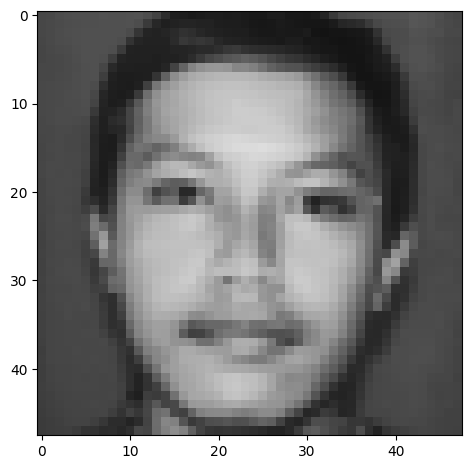

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io

io.imshow(f'{TEST}/tes3.jpg')

In [99]:
#predict

# subfolders = ["happy", "sad"]
fiturtes = []  #glcm

tes = cv2.imread(f"{TEST}/tes5.jpg", cv2.IMREAD_GRAYSCALE)
fiturtes.append(glcm_feature(tes, props=properties))

kolom = []
sudut = ['0', '45', '90','135', '180']
for prop in properties:
    for x in sudut:
        kolom.append(prop + "_" + x)

tes_df = pd.DataFrame(fiturtes, columns=kolom)
pd.set_option('display.max_columns', None)

fitur_tes = tes_df.to_numpy()

prediction = ann.predict(fitur_tes).flatten()

prediction

1/1 [==============================] - 0s 34ms/step


array([0.47124454], dtype=float32)

In [64]:
threshold = 0.5  # Set the threshold value

def cocok_text(prediction):
  # Assuming 'prediction' is the decimal prediction value
  if prediction >= threshold:
      binary_prediction = 1  # Set binary prediction to 1
      print("Happy")
  else:
      binary_prediction = 0  # Set binary prediction to 0
      print("Sad")

def cocok(prediction):
  # Assuming 'prediction' is the decimal prediction value
  if prediction >= threshold:
      return 1  # Set binary prediction to 1
  else:
      return 0  # Set binary prediction to 0

cocok_text(prediction)

Sad


In [95]:
for x in ann.predict(X_test):
  for y in x:
    print(cocok(y))

19/19 [==============================] - 0s 944us/step
1
1
0
1
1
0
1
1
1
1
0
1
0
1
1
1
1
0
1
1
0
1
0
1
0
1
1
1
1
0
0
0
0
1
1
1
0
1
1
1
0
1
1
0
1
1
0
0
0
1
0
0
0
0
0
0
0
1
1
1
0
0
0
1
1
1
0
1
0
0
1
1
0
0
1
0
0
1
1
1
1
1
1
1
1
1
1
0
0
1
0
0
0
1
1
1
0
1
0
0
1
1
1
0
1
1
1
0
0
0
1
1
0
0
1
1
0
1
1
0
0
1
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
1
0
0
1
1
1
0
1
1
1
1
0
0
1
1
0
1
0
0
1
0
0
0
1
1
0
1
1
0
1
0
1
1
0
1
0
1
0
1
1
0
1
0
1
0
0
0
1
1
1
0
0
0
1
1
0
1
0
0
0
1
1
1
0
1
0
0
1
1
0
1
0
1
0
1
1
0
0
1
1
0
0
1
0
0
0
0
0
1
1
1
0
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
1
0
1
0
0
0
1
0
0
1
0
0
0
1
0
1
1
1
1
0
0
1
1
0
1
1
0
1
1
1
0
1
1
1
0
1
1
1
1
0
1
0
1
1
1
1
1
0
1
0
0
1
1
0
1
0
1
1
0
0
1
1
0
0
0
1
1
1
0
1
1
1
0
0
1
0
0
0
0
1
1
1
0
0
1
1
1
1
0
0
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
0
0
0
1
1
1
1
0
1
0
1
0
0
1
0
1
0
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
0
1
1
0
1
0
1
0
1
0
1
0
1
0
1
1
1
1
1
1
0
0
1
0
1
1
1
1
0
1
1
1
0
1
1
0
1
1
0
1
0
1
1
0
1
1
1
1
0
1
0
1
1
1
1
0
1
0
1
1
1
1
1
1
0
1
0
1
1
0
1
1
1
1
1
1

In [ ]:
y_test

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0])

In [100]:
import joblib

joblib.dump(ann ,'model_rangga.joblib')

['model_rangga.joblib']

In [ ]:
import pickle

pickle.dump(ann, open('model_rangga.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-07-03 14:17:20         2288
metadata.json                                  2023-07-03 14:17:20           64
variables.h5                                   2023-07-03 14:17:20       251312
